In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import gseapy as gp
import re
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette

def label_sample(x):
    if 'HS' in x:
        return 'High salt'
    elif 'Frag' in x:
        return 'Fragmented'
    elif re.search('N[aA]', x):
        return 'Alkaline hydrolysis'
    elif re.search('L[12]',x):
        return 'PolyA-selected'
    elif re.search('Exo|ED|DE', x):
        return 'Exonuclease I'
    elif 'All' in x:
        return 'Untreated'
    else:
        return 'Unfragmented'

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize =15)
plt.rc('ytick', labelsize = 15)
colors = okabeito_palette()
colors.append('black')

In [4]:
project_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map'
count_file = project_path + '/Counts/combined_gene_count.tsv'
count_df = pd.read_table(count_file) \
    .assign(grouped_type = lambda d: np.where(d.name.str.startswith('MT-'), 'MT', d.grouped_type))\
    .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))
count_df.head()

,id,grouped_type,type,name,200FN_1_S3_R1_001,200FQ_1_S4_R1_001,200NDP_1_S5_R1_001,200ND_1_S6_R1_001,200ND_2_S7_R1_001,200NH_1_S8_R1_001,...,Qcf_Frag2_R1_001,Qcf_HS1_R1_001,Qcf_HS2_R1_001,Qcf_HS3_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,Qcf_NA2_R1_001,Qcf_Na1_R1_001,S96_cfD_R1_001,S96_cf_R1_001
0,18S_rRNA,rRNA,rDNA,18S_rRNA,626746.5,795566.0,206622.5,70107.0,161960.5,150410.5,...,453747.0,12610.5,28941.5,39821.5,1101.5,795.5,1039.5,1024.0,52694.0,56563.0
1,28S_rRNA,rRNA,rDNA,28S_rRNA,1318143.5,1338619.0,523739.0,152026.5,350603.0,321675.5,...,687675.0,22553.0,59682.0,85376.5,6958.5,9494.0,2013.5,2192.5,138688.0,148357.5
2,5.8S_rRNA,rRNA,rDNA,5.8S_rRNA,58194.5,55894.0,36639.5,92652.5,222217.5,171202.5,...,48748.5,15566.0,35242.0,55183.5,192.0,96.0,123.0,160.5,181203.5,193283.0
3,5S_rRNA,rRNA,rDNA,5S_rRNA,24427.5,81433.5,13364.5,11100.5,32791.5,27038.0,...,39901.0,943.5,4714.0,7261.5,134.0,37.5,58.5,85.5,1706.5,1803.5
4,ENSG00000000003,Protein coding,protein_coding,TSPAN6,0.0,0.0,0.0,0.0,0.0,2.0,...,5.0,0.0,0.0,0.0,3.0,0.0,7.0,15.0,0.0,0.0


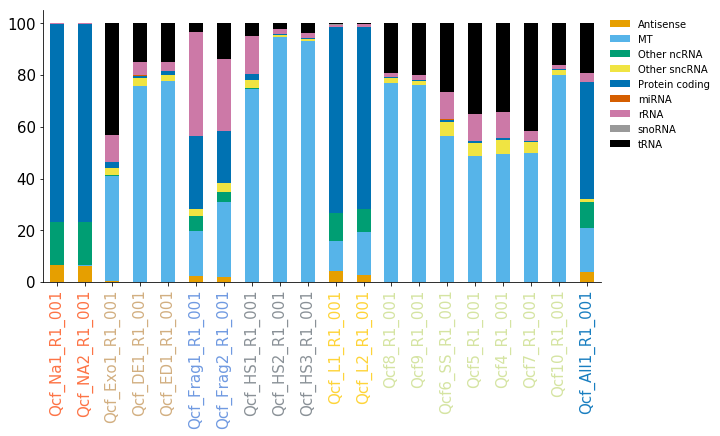

In [10]:
def percentage_columns(d):
    for col in d.columns:
        d[col] = d[col].transform(lambda x: 100*x/x.sum())
    return d

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
bar_df = count_df.drop(['id','type','name'], axis=1)\
    .filter(regex = 'grouped|Qcf')\
    .groupby('grouped_type')\
    .sum() \
    .pipe(percentage_columns)\
    .transpose() \
    .assign(treatment = lambda d: d.index.map(label_sample))
    
bar_df.sort_values('treatment')\
    .drop('treatment', axis=1)\
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1), frameon = False)

ce = color_encoder()
ce.fit_transform(bar_df.treatment, simpsons_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[label_sample(xt.get_text())]
    xt.set_color(color)
sns.despine()

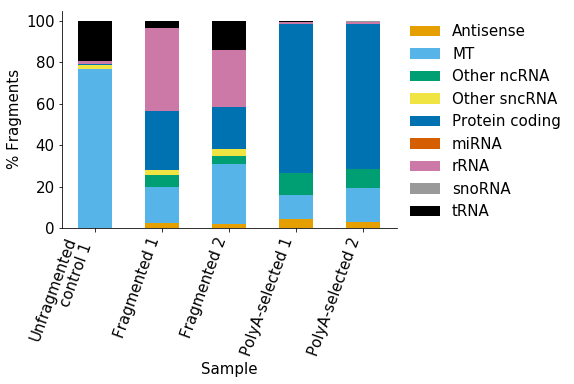

In [5]:
def rename_longRNA(name):
    try:
        x = name.split('_')[1]
        treatment = ''
    
        is_long = 0
        if 'Frag' in x:
            treatment = 'Fragmented'
            is_long = 1
        elif re.search('L[12]', x):
            treatment = 'PolyA-selected'
            is_long = 1
        elif re.search('Qcf[0-9]+',name):
            treatment = 'Unfragmented\ncontrol'
            is_long = 1
    
        if is_long == 1:
            return treatment +' ' + re.search('\d+', x).group(0)
        else:
            return name
    except IndexError:
        return name
        

fig = plt.figure()
ax = fig.add_subplot(111)
count_df\
    .filter(regex = 'grouped|L[12]|Frag|Qcf8')\
    .groupby('grouped_type')\
    .sum() \
    .pipe(percentage_columns)\
    .rename(columns = rename_longRNA)\
    .transpose() \
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1), frameon = False, fontsize=15)
ax.set_xlabel('Sample')
ax.set_ylabel('% Fragments')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right')
sns.despine()

In [6]:
count_df\


,id,grouped_type,type,name,200FN_1_S3_R1_001,200FQ_1_S4_R1_001,200NDP_1_S5_R1_001,200ND_1_S6_R1_001,200ND_2_S7_R1_001,200NH_1_S8_R1_001,...,Qcf_Frag2_R1_001,Qcf_HS1_R1_001,Qcf_HS2_R1_001,Qcf_HS3_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,Qcf_NA2_R1_001,Qcf_Na1_R1_001,S96_cfD_R1_001,S96_cf_R1_001
0,18S_rRNA,rRNA,rDNA,18S_rRNA,626746.5,795566.0,206622.5,70107.0,161960.5,150410.5,...,453747.0,12610.5,28941.5,39821.5,1101.5,795.5,1039.5,1024.0,52694.0,56563.0
1,28S_rRNA,rRNA,rDNA,28S_rRNA,1318143.5,1338619.0,523739.0,152026.5,350603.0,321675.5,...,687675.0,22553.0,59682.0,85376.5,6958.5,9494.0,2013.5,2192.5,138688.0,148357.5
2,5.8S_rRNA,rRNA,rDNA,5.8S_rRNA,58194.5,55894.0,36639.5,92652.5,222217.5,171202.5,...,48748.5,15566.0,35242.0,55183.5,192.0,96.0,123.0,160.5,181203.5,193283.0
3,5S_rRNA,rRNA,rDNA,5S_rRNA,24427.5,81433.5,13364.5,11100.5,32791.5,27038.0,...,39901.0,943.5,4714.0,7261.5,134.0,37.5,58.5,85.5,1706.5,1803.5
4,ENSG00000000003,Protein coding,protein_coding,TSPAN6,0.0,0.0,0.0,0.0,0.0,2.0,...,5.0,0.0,0.0,0.0,3.0,0.0,7.0,15.0,0.0,0.0
5,ENSG00000000005,Protein coding,protein_coding,TNMD,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,1.0,2.0,10.0,14.0,2.0,2.0
6,ENSG00000000419,Protein coding,protein_coding,DPM1,1.0,9.0,1.0,0.0,0.0,3.0,...,7.0,0.0,0.0,0.0,25.0,11.0,28.0,21.0,4.0,4.0
7,ENSG00000000457,Protein coding,protein_coding,SCYL3,0.0,1.0,1.0,2.0,0.0,2.0,...,18.0,0.0,0.0,1.0,12.0,4.0,50.0,66.0,0.0,3.0
8,ENSG00000000460,Protein coding,protein_coding,C1orf112,2.0,4.0,2.0,0.0,2.0,18.0,...,103.0,0.0,0.0,2.0,219.0,45.0,206.0,219.0,28.0,33.0
9,ENSG00000000938,Protein coding,protein_coding,FGR,6.0,1.0,0.0,0.0,0.0,7.0,...,23.0,0.0,0.0,0.0,17.0,24.0,24.0,32.0,1.0,1.0


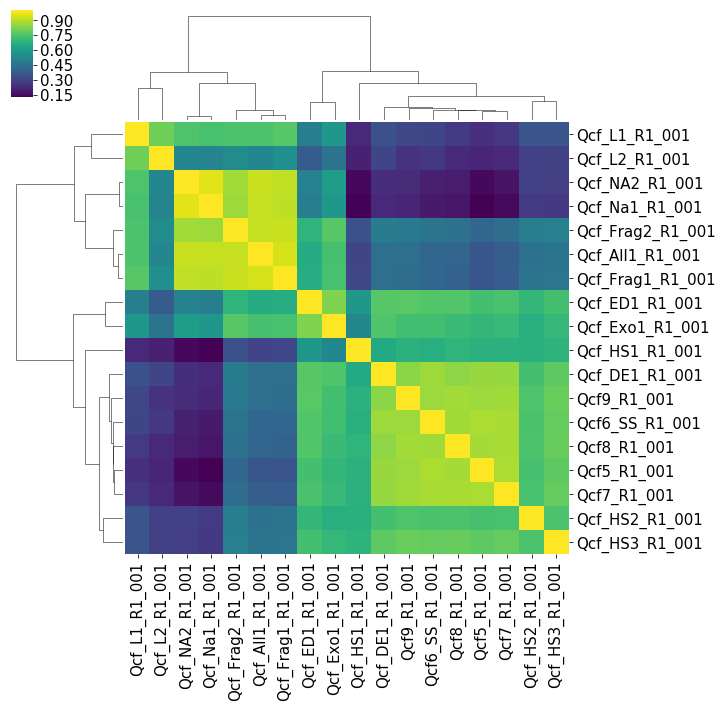

In [7]:
cor_df = np.log(count_df.filter(regex = 'Qcf|QCF').iloc[:, 4:]+1).corr()
p = sns.clustermap(cor_df, cmap = 'viridis')
ax = p.ax_heatmap
xt = ax.set_xticks(range(cor_df.shape[0]))
yt = ax.set_yticks(range(cor_df.shape[1]))
xt = ax.set_xticklabels(cor_df.columns[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[p.dendrogram_row.reordered_ind])

yt = ax.set_yticks(np.arange(cor_df.shape[1])+0.5)
xt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)

In [8]:
def count_to_tpm(count, length):
    rate = count/length
    tpm = rate/rate.sum() * 1e6 
    return tpm

gene_length = pd.read_table('/stor/work/Lambowitz/ref/hg19/genome/genes.length', 
                            names = ['id','glength'])
gene_length.head()

tpm_df = count_df\
    .filter(regex='id|grouped_type|type|name|L[12]|Frag|FQ') \
    .merge(gene_length)
for col in tpm_df.columns:
    if 'Qcf' in col:
        tpm_df[col] = count_to_tpm(tpm_df[col], tpm_df['glength'])
tpm_df.sort_values('Qcf_L1_R1_001', ascending=False).head()

,id,grouped_type,type,name,200FQ_1_S4_R1_001,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,glength
63110,MT-TV,MT,tRNA,MT-TV,54330.0,121140.785500,138450.027845,66938.483710,22854.149090,68
63097,MT-TH,MT,tRNA,MT-TH,80725.0,135053.597678,164128.740076,65437.747823,22264.860492,68
17059,ENSG00000188536,Protein coding,protein_coding,HBA2,880.0,33.593997,11.556480,47989.556331,85557.733494,863
18250,ENSG00000198712,MT,protein_coding,MT-CO2,183.0,127.503186,68.256385,45596.766539,67501.135092,683
63106,MT-TR,MT,tRNA,MT-TR,43506.0,70498.916275,102051.060385,39321.757867,13257.392118,64


In [9]:
tpm_df.query('type == "protein_coding"')\
    .query('Qcf_L1_R1_001 > 0.1 | Qcf_L2_R1_001 > 0.1')\
    .shape

(16591, 10)

In [10]:
gene_expr = '/stor/work/Lambowitz/cdw2854/EV_polyA/published_expr/rna_tissue.tsv'
expr_df = pd.read_table(gene_expr)
expr_df.head()

,Gene,Gene name,Sample,Value,Unit
0,ENSG00000000003,TSPAN6,adipose tissue,31.5,TPM
1,ENSG00000000003,TSPAN6,adrenal gland,26.4,TPM
2,ENSG00000000003,TSPAN6,appendix,9.2,TPM
3,ENSG00000000003,TSPAN6,bone marrow,0.7,TPM
4,ENSG00000000003,TSPAN6,breast,53.4,TPM


In [11]:
top_n = 80
tpm_cor_df = tpm_df.filter(regex='id|Qcf')\
    .rename(columns = {'id':'Gene'})
cor_df = expr_df\
    .pipe(pd.pivot_table, columns = 'Sample', 
          index=['Gene'], values='Value') \
    .reset_index() \
    .merge(tpm_cor_df, on ='Gene', how ='inner')\
    .iloc[:, 1:]\
    .corr(method = 'spearman')\
    .filter(regex = 'Qcf|Frag') \
    .reset_index() \
    .pipe(lambda d: d[~d['index'].str.contains('Qcf')])\
    .sort_values('Qcf_L1_R1_001', ascending=False)\
    .head(top_n)
cor_df.index = cor_df['index']
cor_df.head()

,index,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001
index,,,,,
bone marrow,bone marrow,0.027397,0.080406,0.470444,0.546435
lymph node,lymph node,0.023749,0.077648,0.470366,0.542298
spleen,spleen,0.046577,0.094449,0.469467,0.542860
appendix,appendix,0.044715,0.097736,0.458800,0.528465
tonsil,tonsil,0.010084,0.069231,0.450260,0.515034


Text(1,0.6,"Spearman's $\\rho$")

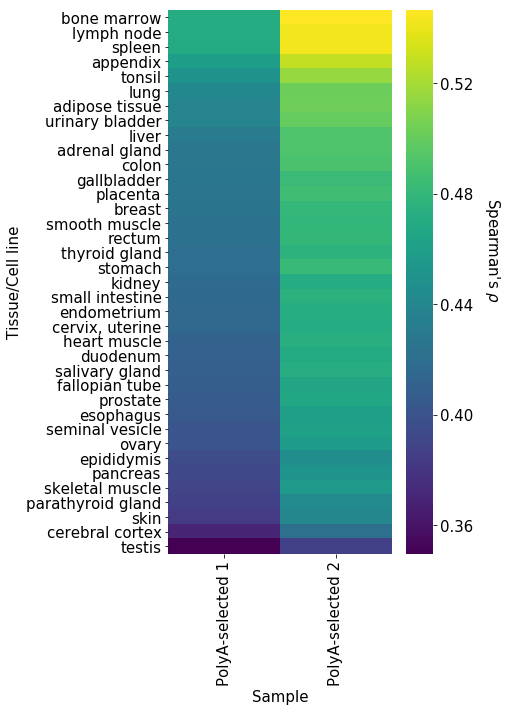

In [12]:
fig = plt.figure(figsize = (5,10))
ax = fig.add_subplot(111)
sns.heatmap(cor_df.filter(regex = 'L[12]').rename(columns = rename_longRNA),
           cmap = 'viridis', ax = ax)
ax.set_xlabel('Sample')
ax.set_ylabel('Tissue/Cell line')
yt = ax.set_yticks(np.arange(cor_df.shape[0])+0.5)
yt = ax.set_yticklabels(cor_df['index'].values, fontsize=15)
fig.text(1,0.6, r"Spearman's $\rho$", rotation = 270, fontsize=15)

Text(0.08,0.85,"Spearman's $\\rho$")

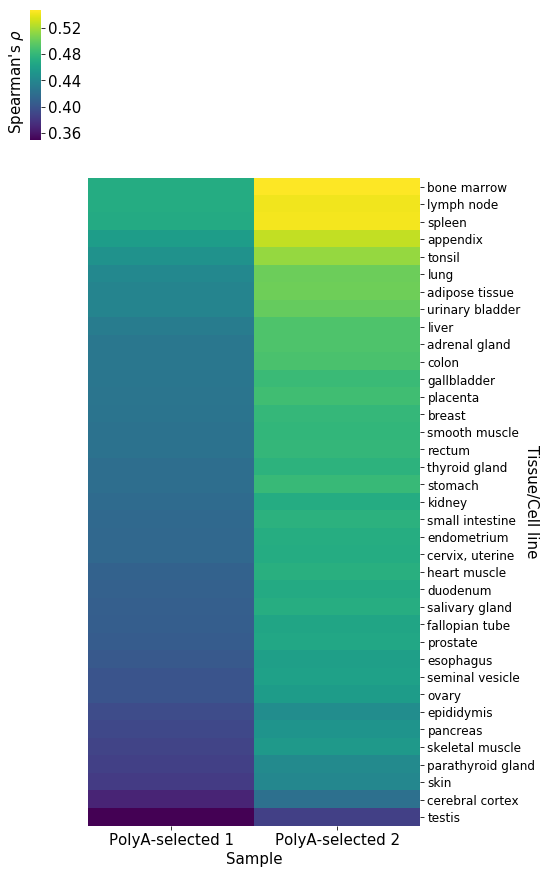

In [13]:
p = sns.clustermap(cor_df.filter(regex = 'L[12]').rename(columns = rename_longRNA),
                row_cluster=False,
                col_cluster=False,
               cmap = 'viridis',
               figsize = (7,15))
ax = p.ax_heatmap
yt = ax.set_yticks(np.arange(cor_df.shape[0])+0.5)
yt = ax.set_yticklabels(cor_df['index'].values, fontsize=12)#[p.dendrogram_row.reordered_ind])
ax.set_xlabel('Sample')
ax.set_ylabel('Tissue/Cell line', rotation=270)
p.fig.text(0.08,0.85, r"Spearman's $\rho$", rotation = 90, fontsize=15)

In [14]:
tpm_df.head()

,id,grouped_type,type,name,200FQ_1_S4_R1_001,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,glength
0,18S_rRNA,rRNA,rDNA,18S_rRNA,795566.0,24076.557144,11255.637183,1134.175355,741.152695,1870
1,28S_rRNA,rRNA,rDNA,28S_rRNA,1338619.0,14866.664985,6336.770089,2661.581268,3285.830304,5034
2,5.8S_rRNA,rRNA,rDNA,5.8S_rRNA,55894.0,34415.581254,14495.546183,2369.812257,1072.150492,156
3,5S_rRNA,rRNA,rDNA,5S_rRNA,81433.5,30021.151710,15424.122275,2150.110912,544.451422,120
4,ENSG00000000003,Protein coding,protein_coding,TSPAN6,0.0,0.106703,0.020487,0.510239,0.000000,11321


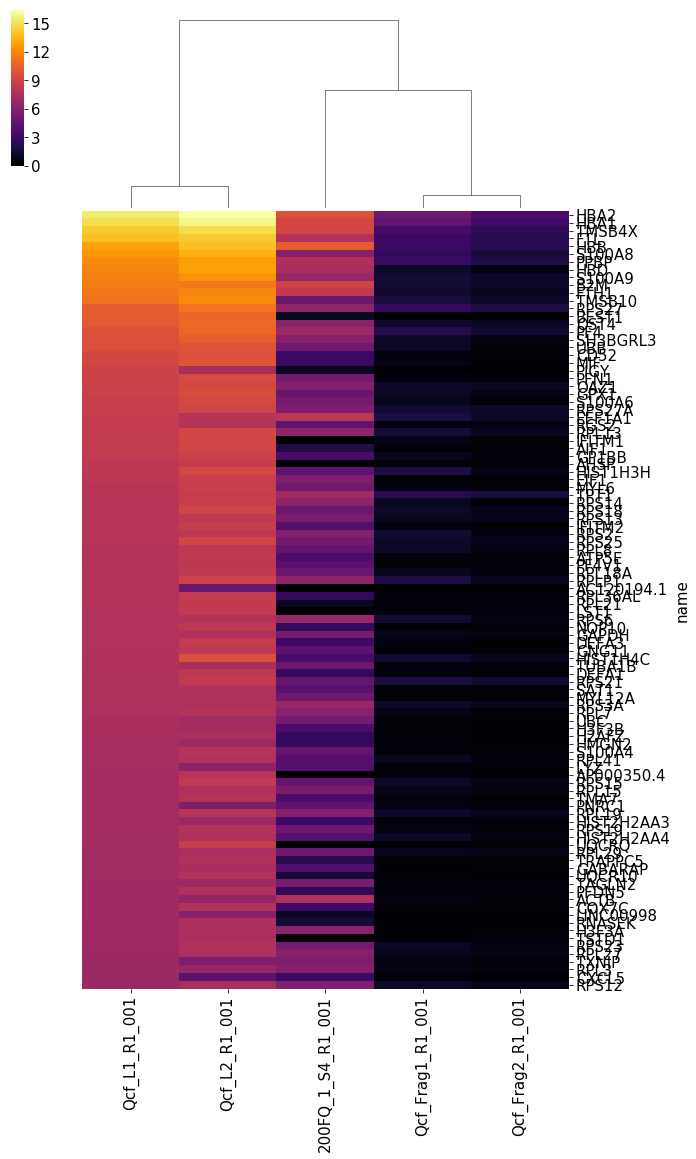

In [15]:
top_n = 100
hd = tpm_df\
    .sort_values('Qcf_L1_R1_001', ascending=False)\
    .query('type == "protein_coding"')\
    .pipe(lambda d: d[~d.name.str.contains('^MT')])
hd.index = hd.name

p = sns.clustermap(np.log2(hd\
                           .head(top_n)\
                           .filter(regex = 'Q')+1),
              row_cluster=False,
              cmap='inferno',
              figsize = (10,18))
ax = p.ax_heatmap
yt = ax.set_yticks(np.arange(top_n) +0.5)
yt = ax.set_yticklabels(hd.index[:top_n])

In [16]:
samplename = 'Qcf_L1_R1_001'

tpm_df = count_df\
    .filter(regex='id|grouped_type|type|name|L[12]|Frag|FQ') \
    .merge(gene_length) \
    .query('type == "protein_coding"')
for col in tpm_df.columns:
    if 'Qcf' in col:
        tpm_df[col] = count_to_tpm(tpm_df[col], tpm_df['glength'])
tpm_df.sort_values('Qcf_L1_R1_001', ascending=False).head()


rank_df = expr_df\
    .pipe(lambda d: d[np.in1d(d.Sample, ['bone marrow', 'lymph node', 'spleen'])])\
    .rename(columns = {'Gene':'id',
                       'Gene name':'name'})\
    .groupby(['id','name'], as_index=False)\
    .agg({'Value':'mean'})\
    .filter(['id','name','Value'])\
    .merge(hd\
            .loc[:,['id','name',samplename]],
          on = ['id','name']) \
    .assign(rank = lambda d: d[samplename].rank() - d['Value'].rank()) \
    .sort_values('rank', ascending=False)
rank_df.head(20)

,id,name,Value,Qcf_L1_R1_001,rank
17945,ENSG00000255072,PIGY,0.0,517.025012,17214.0
13936,ENSG00000180389,ATP5EP2,0.0,95.270773,17118.0
18226,ENSG00000267697,LUZP6,0.0,76.581291,17084.0
16906,ENSG00000206106,KRTAP22-2,0.0,19.782251,16761.0
16186,ENSG00000198128,OR2L3,0.0,12.316455,16550.0
17268,ENSG00000221864,KRTAP12-2,0.0,10.436165,16446.0
17528,ENSG00000236032,OR5H14,0.0,8.922486,16341.0
14482,ENSG00000183706,OR4N4,0.0,8.557655,16315.0
17987,ENSG00000256100,AP000721.4,0.0,8.557032,16314.0
14166,ENSG00000182070,OR52A1,0.0,7.620675,16234.0


In [17]:
rankings = pd.concat([rank_df.head(500), rank_df.tail(500)])

In [18]:
enriched = gp.prerank(rnk=rankings.loc[:,['name','rank']],
           gene_sets='KEGG_2016')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


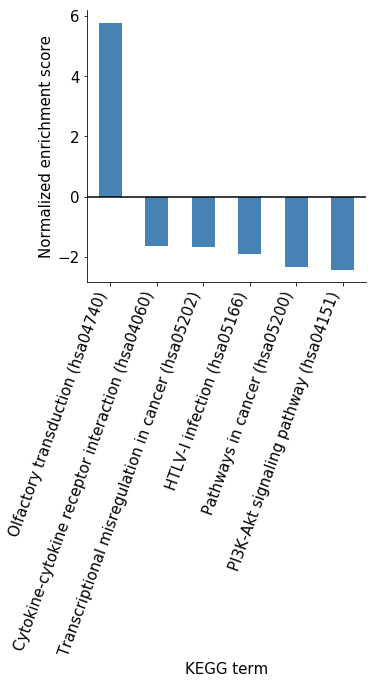

In [19]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
enriched\
        .res2d\
        .reset_index()\
        .assign(log_fdr = lambda d: d.pval.transform(lambda x: -np.log(x or 0.00001)))\
        .sort_values('nes', ascending=False)\
        .assign(Term = lambda d: d.Term.str.replace('_Homo sapiens_',' (') + ')')\
        .plot\
        .bar('Term', 'nes', color = 'steelblue', ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
ax.hlines(y = 0, xmin=-1, xmax=1000)
ax.set_ylabel('Normalized enrichment score')
ax.set_xlabel('KEGG term')
ax.legend().set_visible(False)
sns.despine()

In [20]:
enriched.res2d.sort_values('pval')

,es,nes,pval,fdr,gene_set_size,matched_size,genes
Term,,,,,,,
Olfactory transduction_Homo sapiens_hsa04740,0.798158,5.777536,0.000000,0.000000,415,45,"OR2L3,OR5H14,OR4N4,OR52A1,OR2A12,OR56A1,OR2M3,..."
PI3K-Akt signaling pathway_Homo sapiens_hsa04151,-0.464438,-2.436634,0.000000,0.000000,341,20,"FGF6,FGF21,TSC2,ITGB4,LAMB1,IL6,JAK1,IL7R,IL2R..."
Pathways in cancer_Homo sapiens_hsa05200,-0.410049,-2.327235,0.000000,0.000000,397,24,"BIRC8,FZD9,FGF6,FGF21,LAMB1,IL6,PRKACA,JAK1,DV..."
HTLV-I infection_Homo sapiens_hsa05166,-0.361482,-1.917167,0.012397,0.016260,258,20,"FZD9,CSF2,MSX1,RANBP3,HLA-DOB,ITGAL,ATF3,IL6,T..."
Transcriptional misregulation in cancer_Homo sapiens_hsa05202,-0.359926,-1.686488,0.040598,0.040505,180,16,"HOXA11,CSF2,H3F3C,COMMD3-BMI1,IL6,TCF3,KDM6A,M..."
Cytokine-cytokine receptor interaction_Homo sapiens_hsa04060,-0.300128,-1.633170,0.044211,0.040070,265,22,"IL20,CSF2,IL25,PF4V1,IL26,TSLP,CCL13,IL20RA,IL..."


In [21]:
rnk = enriched
def find_pathway(keyword):
    return [k for k in rnk.results.keys() if keyword in k]

def find_gene(rnk, genes):
    return [i for i, g in enumerate(rnk.rnk.name) if g in genes]

def plot_enrichment(kegg_key):
    assert(kegg_key.startswith('hsa'))
    pathway = find_pathway(kegg_key)[0]
    rnk_dict = rnk.results[pathway]
    genes = rnk_dict['genes']
    res = rnk_dict['rank_ES']

    fig = plt.figure(figsize = (8,8))
    es_ax = fig.add_axes([0, 0.5, 1, 0.5])
    gene_ax = fig.add_axes([0,0.45, 1, 0.049])
    heat_ax = fig.add_axes([0, 0.2, 1, 0.45])
    cor_ax = fig.add_axes([0, 0, 1, 0.4])

    xlims = len(res)

    # enrichment plot
    es_ax.plot(res, linewidth=4, color = 'steelblue')
    es_ax.hlines(xmin = -100, xmax = xlims, y = 0, color = 'black')
    es_ax.set_xlim(0, xlims)
    es_ax.xaxis.set_visible(False)
    es_ax.set_ylabel('Running\nEnrichment\nscore')

    # gene plot
    gene_ax.vlines(ymin = 0, ymax = 1, 
               x = find_gene(rnk, genes), 
               color = 'steelblue')
    gene_ax.set_xlim(0, xlims)
    gene_ax.set_yticklabels([])
    gene_ax.xaxis.set_visible(False)
    gene_ax.text(-50, 0.15,'Pathway\ngene', size = 15, ha = 'right')

    # heat cor
    im = heat_ax.imshow([rnk.ranking.values] * 100, cmap = 'viridis')
    heat_ax.xaxis.set_visible(False)
    heat_ax.yaxis.set_visible(False)

    # cor plot
    cor_ax.plot(rnk.ranking.values, 
            color = 'steelblue')
    cor_ax.fill_between(np.arange(0, xlims), 0, rnk.ranking.values)
    cor_ax.hlines(xmin = -100, xmax = xlims, y = 0, color = 'black')
    cor_ax.set_xlim(0, xlims)
    cor_ax.set_ylabel('Gene rank difference between\nplasma and average of \nbone marrow, lymph node, and spleen')
    cor_ax.set_xlabel('Gene')
    cor_ax.spines['top'].set_visible(False)

    fig.text(0.5, 1.02, pathway.replace('_Homo sapiens_','\n'), size = 20, ha='center')
    
    figurename = '../figures/' + kegg_key + '.png'
    #fig.savefig(figurename, bbox_inches='tight', transparent = True)
    print('Plotted %s' %figurename)

Plotted ../figures/hsa04740.png


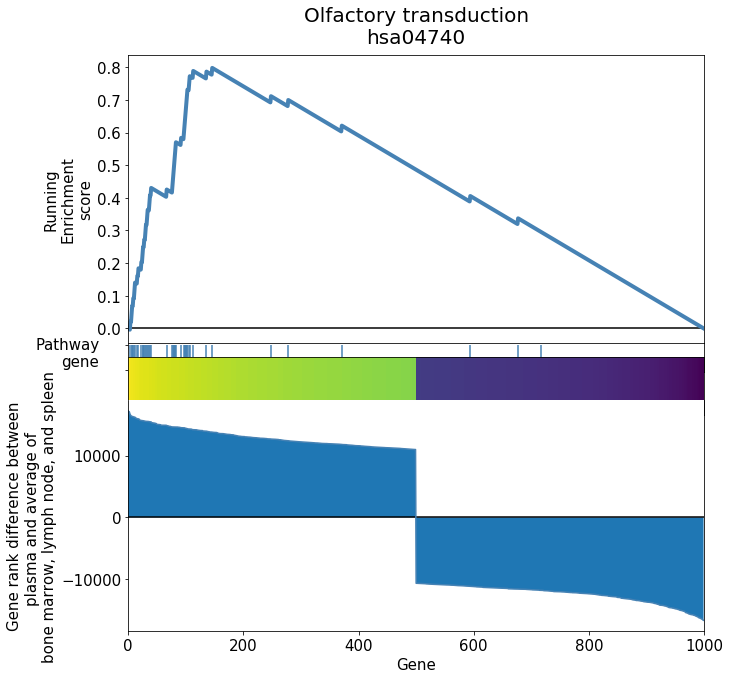

In [22]:
plot_enrichment('hsa04740')

Plotted ../figures/hsa04151.png


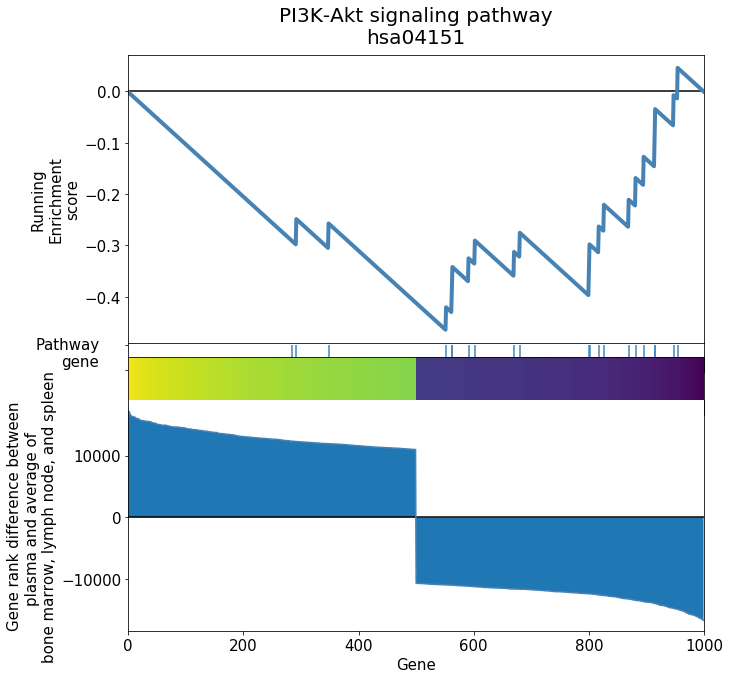

In [23]:
plot_enrichment('hsa04151')

In [24]:
rnk.results['Olfactory transduction_Homo sapiens_hsa04740']['genes']

'OR2L3,OR5H14,OR4N4,OR52A1,OR2A12,OR56A1,OR2M3,OR7C1,OR4X1,OR5AC2,OR8H3,OR5K3,OR5M11,OR10AG1,OR2W1,OR4C3,OR6C1,OR52B2,OR8K1,OR10C1,OR2M5,OR8H2,OR6C70,OR10Z1,OR10G3,OR5H1,OR10G7,OR1G1,OR2A5,OR2T29,OR4C11,OR13G1,OR5P2,OR4A16,OR11H12,OR5H6,OR2F2,OR10G2,OR2B6,OR2T33,OR4N2,OR3A2,OR7A5,PRKACA,PDE2A'

Plotted ../figures/hsa05200.png


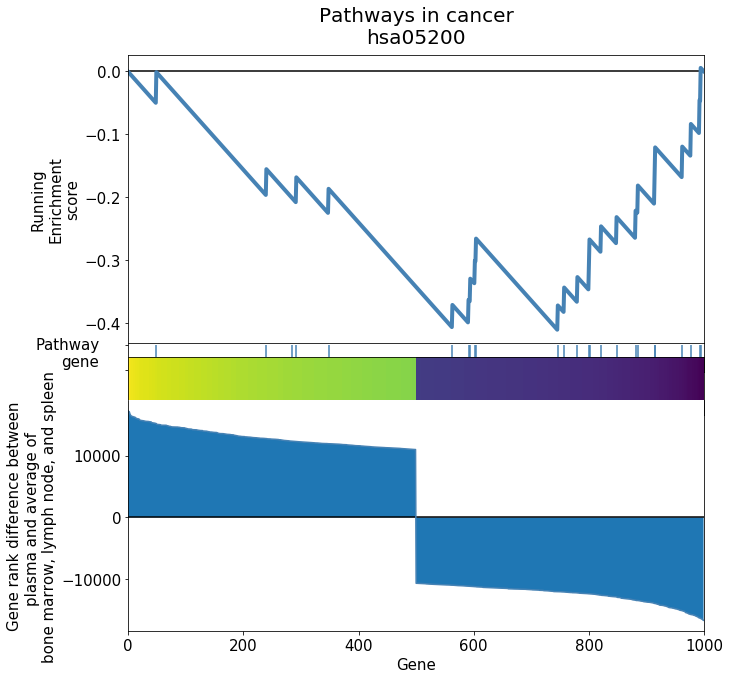

In [25]:
plot_enrichment('hsa05200')

In [26]:
rnk.results['Pathways in cancer_Homo sapiens_hsa05200']['genes']

'BIRC8,FZD9,FGF6,FGF21,LAMB1,IL6,PRKACA,JAK1,DVL2,TRAF4,CTNNB1,CRKL,LAMB2,CDK2,STK4,STAT1,LPAR2,HIF1A,IKBKG,NRAS,NFKB2,RASSF5,MMP9,NCOA4'

In [27]:
rank_df.sort_values('Qcf_L1_R1_001', ascending = False)

,id,name,Value,Qcf_L1_R1_001,rank
15459,ENSG00000188536,HBA2,6268.566667,47989.556331,7.0
16910,ENSG00000206172,HBA1,5809.766667,32682.722541,8.0
16834,ENSG00000205542,TMSB4X,9251.033333,20260.622657,1.0
1667,ENSG00000087086,FTL,3950.900000,15299.997070,11.0
17772,ENSG00000244734,HBB,26265.600000,8121.173586,-4.0
8095,ENSG00000143546,S100A8,5240.666667,6341.067171,5.0
10638,ENSG00000163736,PPBP,44.966667,4897.577919,1912.0
17326,ENSG00000223609,HBD,407.966667,4044.064369,154.0
10482,ENSG00000163220,S100A9,7406.133333,3539.034157,-2.0
11390,ENSG00000166710,B2M,3201.133333,3312.853425,9.0


In [28]:
cor_df = expr_df\
    .pipe(pd.pivot_table, columns = 'Sample', 
          index=['Gene', 'Gene name'], values='Value') \
    .reset_index() \
    .pipe(lambda d: d[~d['Gene name'].str.contains('^MT')])\
    .merge(tpm_cor_df.rename(columns=rename_longRNA), on ='Gene', how ='inner') \
    .sort_values('PolyA-selected 1', ascending=False)
cor_df.index= cor_df['Gene name']
cor_df.head(10)

,Gene,Gene name,adipose tissue,adrenal gland,appendix,bone marrow,breast,cerebral cortex,"cervix, uterine",colon,...,spleen,stomach,testis,thyroid gland,tonsil,urinary bladder,Fragmented 1,Fragmented 2,PolyA-selected 1,PolyA-selected 2
Gene name,,,,,,,,,,,,,,,,,,,,,
HBA2,ENSG00000188536,HBA2,226.0,336.7,218.0,18369.0,213.0,59.0,73.2,78.2,...,427.2,32.4,13.3,55.4,8.2,28.5,33.593997,11.556480,47989.556331,85557.733494
HBA1,ENSG00000206172,HBA1,142.9,233.6,143.1,17119.3,110.9,48.3,34.8,58.1,...,303.5,20.4,9.4,35.4,3.9,17.1,21.650331,8.869757,32682.722541,61454.469262
TMSB4X,ENSG00000205542,TMSB4X,3805.9,5439.9,6688.8,5468.2,3675.2,2891.0,4421.5,4173.9,...,10744.7,4224.3,928.3,1529.5,6487.7,5915.7,10.157660,4.772253,20260.622657,32058.450792
FTL,ENSG00000087086,FTL,4755.5,2291.2,3208.8,2600.5,2719.6,1997.8,2925.6,2081.9,...,5838.2,1280.3,889.4,2427.0,1209.1,3753.2,7.102922,3.823927,15299.997070,20044.098200
HBB,ENSG00000244734,HBB,627.5,654.3,306.3,78046.6,854.1,85.0,283.8,266.8,...,720.7,48.9,30.1,456.2,37.1,180.5,7.179573,4.165523,8121.173586,15252.063516
S100A8,ENSG00000143546,S100A8,464.5,22.0,1232.5,14915.7,36.9,11.7,176.7,25.4,...,786.1,10.9,13.0,12.6,4867.3,166.9,5.224845,2.126748,6341.067171,11207.033278
PPBP,ENSG00000163736,PPBP,2.3,1.4,1.6,110.6,1.1,0.5,0.1,0.2,...,24.3,0.1,0.0,1.6,0.0,0.7,6.727341,3.081805,4897.577919,7427.463606
HBD,ENSG00000223609,HBD,0.1,0.3,0.7,1221.3,0.0,0.0,0.0,0.4,...,2.2,0.2,0.1,0.1,0.1,0.1,1.264606,0.413556,4044.064369,7803.210450
S100A9,ENSG00000163220,S100A9,794.0,53.5,2087.4,20959.3,51.3,20.9,255.9,42.7,...,1188.6,17.2,16.6,29.3,3911.6,1006.1,1.834317,1.242644,3539.034157,5898.263773


Text(0.1,0.85,'TPM ($log_2$)')

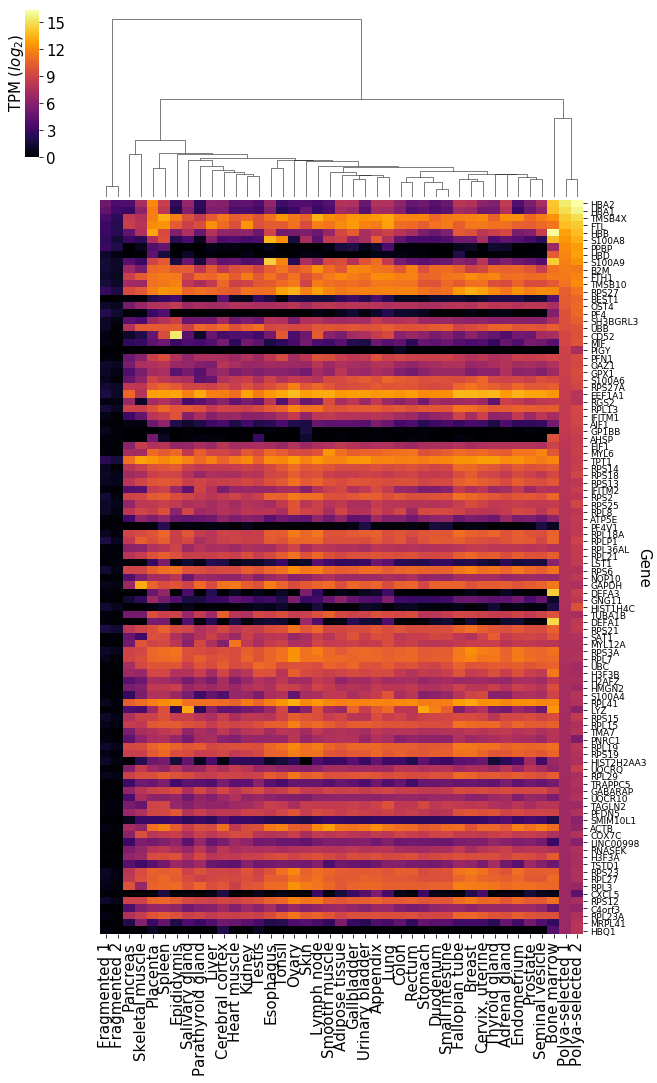

In [29]:
top_n = 100
p = sns.clustermap(np.log2(cor_df.iloc[:top_n,2:]+1),
                   row_cluster=False,
                  figsize = (10,17),
                  cmap = 'inferno')
ax = p.ax_heatmap
xt = ax.set_yticks(np.arange(top_n)+0.5)
yt = ax.set_xticks(np.arange(cor_df.shape[1] - 2) + 0.5)
xt = ax.set_xticklabels(cor_df.columns[2:].str.capitalize()[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[:top_n], fontsize=9)
ax.set_ylabel('Gene', rotation = 270)
p.fig.text(0.1,0.85, r'TPM ($log_2$)', rotation = 90, fontsize=15)

Text(0.9,0.5,'TPM ($log_2$)')

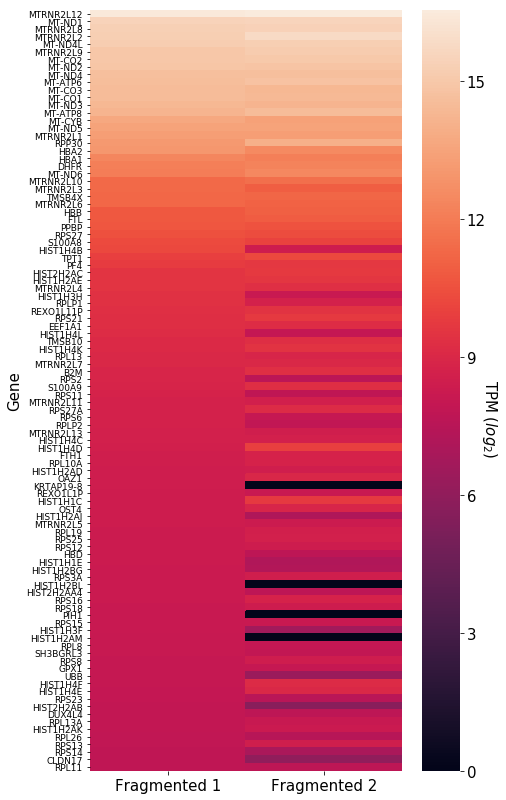

In [30]:
fig = plt.figure(figsize=(7,14))
ax = plt.subplot(111)
frag_df = tpm_df\
    .filter(regex='id|name|type|Frag')\
    .sort_values('Qcf_Frag1_R1_001', ascending=False)\
    .set_index('name')
p = sns.heatmap(np.log2(frag_df.iloc[:top_n,-2:]+1), ax =ax)
xt = ax.set_yticks(np.arange(top_n)+0.5)
yt = ax.set_xticks(np.arange(2) + 0.5)
xt = ax.set_xticklabels(frag_df.columns[-2:].map(rename_longRNA))
yt = ax.set_yticklabels(frag_df.index[:top_n], fontsize=9)
ax.set_ylabel('Gene', rotation = 90)
fig.text(0.9,0.5, r'TPM ($log_2$)', rotation = 270, fontsize=15)

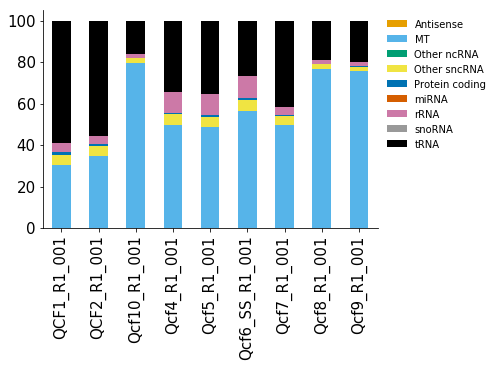

In [31]:
ax = plt.subplot(111)
count_df.filter(regex='grou|Q[cC][Ff][0-9]+')\
    .groupby('grouped_type')\
    .sum() \
    .pipe(percentage_columns)\
    .transpose() \
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1), frameon = False)
sns.despine()

In [19]:
dedup_df = pd.read_table('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')
dedup_df.head()

,gene_id,gene_name,gene_type,grouped_type,200FN_1_S3_R1_001:all:antisense,200FN_1_S3_R1_001:all:sense,200FN_1_S3_R1_001:dedup:antisense,200FN_1_S3_R1_001:dedup:sense,200FQ_1_S4_R1_001:all:antisense,200FQ_1_S4_R1_001:all:sense,...,Qcf_Na1_R1_001:dedup:antisense,Qcf_Na1_R1_001:dedup:sense,S96-cfD_R1_001:all:antisense,S96-cfD_R1_001:all:sense,S96-cfD_R1_001:dedup:antisense,S96-cfD_R1_001:dedup:sense,S96-cf_R1_001:all:antisense,S96-cf_R1_001:all:sense,S96-cf_R1_001:dedup:antisense,S96-cf_R1_001:dedup:sense
0,18S_rRNA,18S_rRNA,rDNA,rDNA,1789,1253493,1408,867335,2500,1591132,...,901,1880,575,105388,359,46970,945,113126,583,48893
1,28S_rRNA,28S_rRNA,rDNA,rDNA,1795,2636287,1447,1692392,2133,2677238,...,1422,4006,1006,277376,597,109543,1340,296715,787,113377
2,5.8S_rRNA,5.8S_rRNA,rDNA,rDNA,135,116389,110,44882,127,111788,...,101,294,67,362407,32,15992,74,386566,34,16284
3,5S_rRNA,5S_rRNA,rDNA,rDNA,27,48855,21,18586,79,162867,...,65,157,6,3413,5,1355,6,3607,5,1393
4,Alu,SINE:AluJb,Repeats,Repeats,197,209,169,169,403,787,...,39517,47502,3022,2676,1727,1418,3315,3042,1865,1632


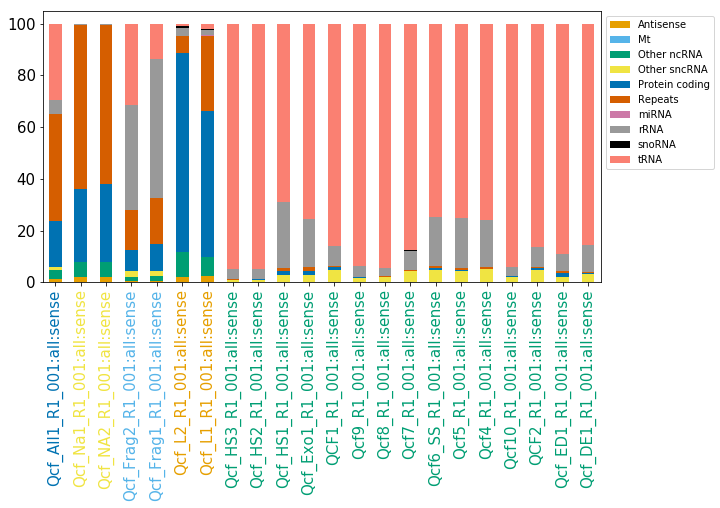

In [25]:
from tgirt_map.table_tool import change_gene_type
from sequencing_tools.viz_tools import color_encoder, simpsons_palette

def label_treatment(x, return_label=False):
    if 'All' in x:
        return 'Total nucleic acid' if return_label else 1
    elif re.search('NA|Na', x):
        return 'Alkaline hydrolysis' if return_label else 2
    elif re.search('Frag|frag', x):
        return 'Fragmented' if return_label else 3
    elif re.search('L[12]', x):
        return 'PolyA-selected' if return_label else 4
    else:
        return 'DNase-treatment' if return_label else 5

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
colors.append('salmon')
dedup_df\
    .assign(gene_type = lambda d: d.gene_type.map(change_gene_type))\
    .filter(regex = 'type|Qcf|QCF')\
    .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
    .groupby('grouped_type')\
    .sum() \
    .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
    .pipe(lambda d: d[d.columns[~d.columns.str.contains('dedup')]])\
    .pipe(percentage_columns)\
    .transpose() \
    .assign(prep = lambda d: d.index.map(label_treatment))\
    .sort_values('prep')\
    .drop('prep', axis=1)\
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1))

preps = [label_treatment(_.get_text(), return_label=True) for _ in ax.get_xmajorticklabels()]
ce = color_encoder()
ce.fit(preps)
for _, pre in zip(ax.get_xmajorticklabels(),preps):
    _.set_color(ce.encoder[pre])

# Exon plot #

In [41]:
def RNA_base_from_picard(metrics):
    metric_tables = {os.path.basename(met):pd.read_table(met, skiprows=10) for met in metrics}
    cov_df = pd.concat([df.assign(sample = sam)for sam, df in metric_tables.items()])
    return cov_df

def label_sample()

In [56]:
import glob
import os 
metrics = glob.glob('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/picard_qc/*deduplicated.RNA_Metrics')
cov_df = RNA_base_from_picard(metrics) 
cov_df.head()

,normalized_position,All_Reads.normalized_coverage,sample
0,0,0.101990,450_NT_2_S6_R1_001_deduplicated.RNA_Metrics
1,1,0.107989,450_NT_2_S6_R1_001_deduplicated.RNA_Metrics
2,2,0.203980,450_NT_2_S6_R1_001_deduplicated.RNA_Metrics
3,3,0.203980,450_NT_2_S6_R1_001_deduplicated.RNA_Metrics
4,4,0.173983,450_NT_2_S6_R1_001_deduplicated.RNA_Metrics


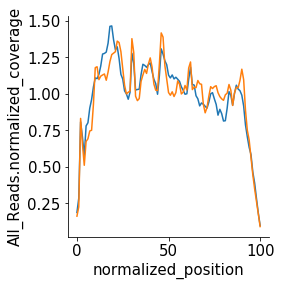

In [60]:
p = sns.FacetGrid(data = cov_df.pipe(lambda d: d[d['sample'].str.contains('Frag')]), 
                  hue = 'sample',
                 size = 4)
p.map(plt.plot, 'normalized_position', 'All_Reads.normalized_coverage')

In [59]:
cov_df.pipe(lambda d: d[d['sample'].str.contains('Frag')])

,normalized_position,All_Reads.normalized_coverage,sample
0,0,0.188378,Qcf_Frag1_R1_001_deduplicated.RNA_Metrics
1,1,0.286058,Qcf_Frag1_R1_001_deduplicated.RNA_Metrics
2,2,0.808221,Qcf_Frag1_R1_001_deduplicated.RNA_Metrics
3,3,0.704663,Qcf_Frag1_R1_001_deduplicated.RNA_Metrics
4,4,0.578816,Qcf_Frag1_R1_001_deduplicated.RNA_Metrics
5,5,0.780923,Qcf_Frag1_R1_001_deduplicated.RNA_Metrics
6,6,0.802439,Qcf_Frag1_R1_001_deduplicated.RNA_Metrics
7,7,0.902475,Qcf_Frag1_R1_001_deduplicated.RNA_Metrics
8,8,0.960890,Qcf_Frag1_R1_001_deduplicated.RNA_Metrics
9,9,1.047596,Qcf_Frag1_R1_001_deduplicated.RNA_Metrics
